# Modeling the pulsar polarisation data assuming free precession

In [20]:
from __future__ import print_function, division
import sys
import psrchive
import numpy as np
from ultranest import ReactiveNestedSampler, stepsampler
import glob
import matplotlib.pyplot as plt
import configparser
from numba import njit
from numba.typed import List
from rvm import rvm

In [21]:
@njit(fastmath=True)
def get_L(cube, have_EFAC, nQ, nU, xm, Qm, Um):
    
        nfiles = len(xm)
        zeta = np.deg2rad(cube[:,0])
        betas = np.deg2rad(cube[:,1:1+nfiles])
        phi0s = np.deg2rad(cube[:,1+nfiles:1+2*nfiles])
        psi0s = np.deg2rad(cube[:,1+2*nfiles:1+3*nfiles])
        
        if have_EFAC:
            EFAC = np.expand_dims(cube[:,1+3*nfiles], -1)
        else:
            EFAC = np.array([[1.]])
        
        chi = np.zeros(cube.shape[0])       
        logdet = np.zeros(cube.shape[0])
        zeta = np.expand_dims(zeta, -1)
        for ii in range(nfiles):
            
            beta = np.expand_dims(betas[:,ii], -1)
            phi0 = np.expand_dims(phi0s[:,ii], -1)
            psi0 = np.expand_dims(psi0s[:,ii], -1)

            nQ2 = nQ[ii]*nQ[ii] * EFAC*EFAC
            nU2 = nU[ii]*nU[ii] * EFAC*EFAC

            x = np.expand_dims(xm[ii], axis=0)

            # Compute the modelled PA            
            zb = zeta-beta
            sinzb = np.sin(zb)
            xp = x-phi0

            argx = np.cos(zb)*np.sin(zeta) - sinzb*np.cos(zeta)*np.cos(xp)
            argy =  sinzb * np.sin(xp)

            PA2 = 2*(-np.arctan(argy/argx) + psi0)
            cos2PA = np.cos(PA2)
            sin2PA = np.sin(PA2)

            L = (Qm[ii] * cos2PA/nQ2 + Um[ii] * sin2PA/nU2) / (cos2PA*cos2PA/nQ2 + sin2PA*sin2PA/nU2) * np.exp(1j*PA2)
            
            chi += np.sum((Qm[ii]-np.real(L))**2 / nQ2 + (Um[ii]-np.imag(L))**2 / nU2, axis=-1)
            logdet += len(Qm[ii]) * np.sum(np.log(nQ2) + np.log(nU2), axis=-1)
        return -0.5 * chi -0.5*logdet


In [22]:
class Precessnest():
    def __init__(self, filenames, sig=5, have_EFAC=False, config = None):
    
        self.nI = np.array([])
        self.nQ = np.array([])
        self.nU = np.array([])
        self.xm = List()
        self.Qm = List()
        self.Um = List()

        self.nfiles = len(filenames)
        self.labels = []
        self.have_EFAC = have_EFAC
        
        for filename in filenames:
            self.get_data(filename, sig=sig)
        
        # Check if we have to exclude phase range from the data
        if config.has_section('exc_phases'):
            self.exc_phs(config['exc_phases'])

        self.set_pZeta(config['zeta'])
        self.set_pBeta(config['beta'])
        self.set_pPhi0(config['phi'])
        self.set_pPsi0(config['psi'])         
        
        for ii in range(self.nfiles):
            self.xm[ii] = self.xm[ii].compressed()
            self.Qm[ii] = self.Qm[ii].compressed() 
            self.Um[ii] = self.Um[ii].compressed()
       
        self.set_labels()

    def set_pZeta(self, pZe):
        for item in pZe.items():
            key = item[0]; val=item[1]

        xval = np.array(val.rstrip().split(';'))            
        val = xval.astype(float)
        self.pZe=(val[0],val[1])
        
    def __set_range(self, c):
        tmp = np.zeros((2, self.nfiles))
        for iprof,key in enumerate(c.keys()):            
            xval = np.array(c[key].rstrip().split(';'))            
            val = xval.astype(float)
            tmp[0,iprof] = val[0]; tmp[1,iprof] = val[1]
            
            if iprof+1 == self.nfiles:
                break
        return tmp       
        
    def set_pBeta(self, pBe):
        
        # Check if we have the right number of inputs vs number of files
        if len(pBe) < self.nfiles:
            raise ValueError("Number of Beta priors in config file (%d) does not match the number of profiles (%d)"%(len(pBe), self.nfiles))  
            
        self.pBe = self.__set_range(pBe)
        
    def set_pPhi0(self, pPh):
        # Check if we have the right number of inputs vs number of files
        if len(pPh) < self.nfiles:
            raise ValueError("Number of Phi0 priors in config file (%d) does not match the number of profiles (%d)"%(len(pBe), self.nfiles))  
            
        # For each entry in config file for phase range exclusion
        self.pPh = self.__set_range(pPh)
                
    def set_pPsi0(self, pPs):
        # Check if we have the right number of inputs vs number of files
        if len(pPs) < self.nfiles:
            raise ValueError("Number of Psi0 priors in config file (%d) does not match the number of profiles (%d)"%(len(pBe), self.nfiles))  
            
        # For each entry in config file for phase range exclusion
        self.pPs = self.__set_range(pPs)
        
    def set_labels(self):
        self.labels.extend(["zeta"])
        self.labels.extend(['beta_%d'%i for i in range(self.nfiles)])
        self.labels.extend(['phi0_%d'%i for i in range(self.nfiles)])
        self.labels.extend(['psi0_%d'%i for i in range(self.nfiles)])      
        if self.have_EFAC:
            self.labels.extend(["EFAC"])
   
    def get_labels(self):
        return self.labels

    def Prior(self, cube):

        pcube = np.zeros(cube.shape)
        ipar = 0

        # Zeta
        pcube[:,ipar] = cube[:,ipar]*(self.pZe[1]-self.pZe[0])+self.pZe[0]; ipar +=1
        pcube[:,ipar:ipar+self.nfiles] = cube[:,ipar:ipar+self.nfiles]*(self.pBe[1]-self.pBe[0])+self.pBe[0]; ipar += self.nfiles
        pcube[:,ipar:ipar+self.nfiles] = cube[:,ipar:ipar+self.nfiles]*(self.pPh[1]-self.pPh[0])+self.pPh[0]; ipar += self.nfiles
        pcube[:,ipar:ipar+self.nfiles] = cube[:,ipar:ipar+self.nfiles]*(self.pPs[1]-self.pPs[0])+self.pPs[0]; ipar += self.nfiles
        
        # EFAC
        if self.have_EFAC:
            pcube[:,ipar] = cube[:,ipar]*2+.3
        return pcube
        
    def get_data(self, filename,sig=5):
        print(filename)
        ar = psrchive.Archive_load(filename)
        ar.tscrunch()
        ar.fscrunch()
        ar.convert_state('Stokes')
        ar.remove_baseline()
        #ar.
        
        self.nbin = ar.get_nbin()

        data = ar.get_data()
        x = np.arange(0, ar.get_nbin()) / ar.get_nbin()*2*np.pi
        I = data[:,0,:,:][0][0]
        Q = data[:,1,:,:][0][0]
        U = data[:,2,:,:][0][0]
        V = data[:,3,:,:][0][0]
        L = np.sqrt(Q*Q+U*U)
        PA = 0.5*np.arctan2(U,Q)

        integ = ar.get_first_Integration()
        # Get baseline RMS (1) for total intensity (0)
        nI = np.sqrt((integ.baseline_stats()[1][0]))
        nQ = np.sqrt((integ.baseline_stats()[1][1]))
        nU = np.sqrt((integ.baseline_stats()[1][2]))
        
        xm = np.ma.masked_where(L<sig*nI,x)
        Qm = np.ma.masked_where(L<sig*nI,Q)
        Um = np.ma.masked_where(L<sig*nI,U)
        
        self.nI = np.append(self.nI, nI)
        self.nQ = np.append(self.nQ, nQ)
        self.nU = np.append(self.nU, nU)
        self.xm.append(xm)
        self.Qm.append(Qm)
        self.Um.append(Um)

    def exc_phs(self, exc):
        # Check if we have the right number of inputs vs number of files
        if len(exc) < self.nfiles:
            raise ValueError("Number of input in config file (%d) does not match the number of profiles (%d)"%(len(exc), self.nfiles))
            
        # For each entry in config file for phase range exclusion
        for iprof,key in enumerate(exc.keys()):            
            xval = np.array(exc[key].rstrip().split(';'))            
            val = xval.astype(float)
            # Mask data by range and compress later
            pairs = zip(val[::2], val[1::2])
            for p in pairs:
                print(p)
                self.xm[iprof][int(p[0]*self.nbin):int(p[1]*self.nbin)] = np.ma.masked
                self.Qm[iprof][int(p[0]*self.nbin):int(p[1]*self.nbin)] = np.ma.masked
                self.Um[iprof][int(p[0]*self.nbin):int(p[1]*self.nbin)] = np.ma.masked
                
            if iprof+1== self.nfiles:
                break
             
       
    def LogLikelihood(self, cube):
        
        return get_L(cube, self.have_EFAC, self.nQ, self.nU, self.xm, self.Qm, self.Um)


             


In [32]:
# Input filenames
filenames = glob.glob("/data/paper_1810/simulations/free/sim_*.ar")
cfgfilename = "/data/paper_1810/simulations/free/config.ini"

# Threshold for L (in sigma)
sig = 5

have_EFAC = False

pZe = (140,180)
pBe = (-10,10)
pPh = (170,190)
pPs = (35,55)

cfg = configparser.ConfigParser(allow_no_value=True)
cfg.read(cfgfilename)



['/data/paper_1810/simulations/free/config.ini']

In [33]:
# RUN THE ANALYSIS
Ndim = 1 + 3*len(filenames)
if have_EFAC == True:
    Ndim += 1    
print("Ndim = %d\n"%Ndim)

model = Precessnest(filenames, sig=sig, have_EFAC=have_EFAC, config=cfg)

paramnames = model.get_labels()


Ndim = 52

/data/paper_1810/simulations/free/sim_0.ar
/data/paper_1810/simulations/free/sim_1.ar
/data/paper_1810/simulations/free/sim_10.ar
/data/paper_1810/simulations/free/sim_11.ar
/data/paper_1810/simulations/free/sim_12.ar
/data/paper_1810/simulations/free/sim_13.ar
/data/paper_1810/simulations/free/sim_14.ar
/data/paper_1810/simulations/free/sim_15.ar
/data/paper_1810/simulations/free/sim_16.ar
/data/paper_1810/simulations/free/sim_2.ar
/data/paper_1810/simulations/free/sim_3.ar
/data/paper_1810/simulations/free/sim_4.ar
/data/paper_1810/simulations/free/sim_5.ar
/data/paper_1810/simulations/free/sim_6.ar
/data/paper_1810/simulations/free/sim_7.ar
/data/paper_1810/simulations/free/sim_8.ar
/data/paper_1810/simulations/free/sim_9.ar


In [34]:
%%time
sampler = ReactiveNestedSampler(paramnames, model.LogLikelihood, transform=model.Prior, vectorized=True, log_dir="/data/magnetar-1809-1943/sim/")
#nsteps = 2 * len(paramnames)
# create step sampler:
#sampler.stepsampler = stepsampler.RegionSliceSampler(nsteps=nsteps, adaptive_nsteps='move-distance')
#sampler.stepsampler = stepsampler.RegionSliceSampler(nsteps=400, adaptive_nsteps='move-distance')
res = sampler.run()


Creating directory for new run /data/magnetar-1809-1943/sim/run24
[ultranest] Sampling 400 live points from prior ...


KeyboardInterrupt: 

In [25]:
sampler.print_results()


logZ = 10998.702 +- 0.555
  single instance: logZ = 10998.702 +- 0.370
  bootstrapped   : logZ = 10998.736 +- 0.555
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    zeta                : 156.0 │ ▁▁ ▁▁▁▁▁▁▂▂▃▄▄▅▇▇▇▇▇▇▆▅▅▃▃▂▂▁▁▁▁▁▁▁ ▁ │178.0     167.2 +- 2.7
    beta_0              : -5.56 │ ▁  ▁▁▁▁▁▁▂▂▃▄▄▅▇▆▇▇▇▇▆▅▅▃▃▂▂▁▁▁▁▁▁▁ ▁ │-0.49     -2.99 +- 0.62
    beta_1              : -3.99 │ ▁  ▁▁▁▁▁▁▂▂▃▄▄▅▇▇▇▇▇▇▆▅▅▃▃▂▂▁▁▁▁▁▁▁ ▁ │-0.34     -2.15 +- 0.44
    beta_2              : -2.39 │ ▁▁ ▁▁▁▁▁▁▂▂▃▃▄▅▇▇▇▇▇▇▆▅▅▃▃▂▂▁▁▁▁▁▁▁ ▁ │-0.21     -1.28 +- 0.26
    beta_3              : -0.799│ ▁▁ ▁▁▁▁▁▁▂▂▃▄▄▅▇▇▇▇▇▇▇▆▅▄▃▂▂▁▁▁▁▁▁▁ ▁ │-0.070    -0.429 +- 0.088
    phi0_0              : 179.75│ ▁▁▁▁▁▁▁▁▁▂▃▃▄▄▆▇▆▇▇▇▇▆▅▄▃▃▂▁▁▁▁▁▁▁▁▁▁ │180.62    180.18 +- 0.10
    phi0_1              : 179.576│ ▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆▆▇▇▇▇▇▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁ │180.169    179.865 +- 0.067
    phi0_2              : 179.801│ ▁ ▁ ▁▁▁▁▁▁▁▂▂▄▄▆▇▇▇▇▇▆▅▄▃▂▂▂▁▁▁▁▁▁  ▁ │180.135    179.970 +-

In [450]:
#sampler.plot_corner()

Text(0, 0.5, 'PA (deg)')

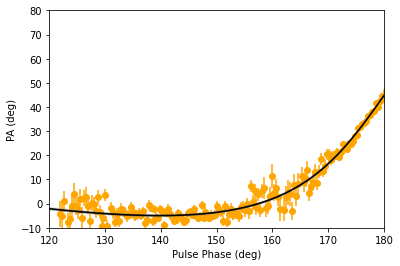

In [24]:
iprof = 0
L = (model.Um[iprof]**2 + model.Qm[iprof]**2)**.5
PA = np.rad2deg(0.5*np.arctan2(model.Um[iprof][:],model.Qm[iprof][:]))
PAe = 28.65 * model.nI[iprof]/ L
plt.errorbar(x=np.rad2deg(model.xm[iprof]), y=PA, yerr=PAe,
             marker='o', ls=' ', color='orange',zorder=-5)

t_grid = np.linspace(0, 360, 400)

from ultranest.plot import PredictionBand
band = PredictionBand(t_grid)

for l in sampler.results['samples']:

    zeta = l[0]
    beta = l[1+iprof:2+iprof]
    phi0 = l[1+model.nfiles+iprof:2+model.nfiles+iprof]
    psi0 = l[1+2*model.nfiles+iprof:2+2*model.nfiles+iprof]
    band.add(np.rad2deg(rvm.rvm(t_grid,zeta,beta,phi0,psi0)))
    
    
band.line(color='k')
# add 1 sigma quantile
band.shade(color='k', alpha=0.3)
# add wider quantile (0.01 .. 0.99)
band.shade(q=0.49, color='gray', alpha=0.2)
plt.xlim(120,180)
plt.ylim(-10,80)
plt.xlabel("Pulse Phase (deg)")
plt.ylabel("PA (deg)")

In [47]:
%%time
a = model.LogLikelihood(np.ones((400,53)))

CPU times: user 99.4 ms, sys: 10.1 ms, total: 109 ms
Wall time: 108 ms
